# Exogenous degrees of freedom

Thus far, the motion of bodies or of incident flows has been prescribed
with time-varying functions known a priori. In other words, we knew
in advance how the body or free stream would behave for all time. However,
it is often the case that we do *not* know the motion in advance, because,
e.g., that motion depends on the evolving state of the fluid flow. That is
the case for fluid-body interactions, in which the body motion depends
on the forces imparted by the fluid on the body. It is also the
case for active feedback control or reinforcement learning, in which
a controller/agent might change some degree of freedom based on what
is observed.

We will refer to such a degree of freedom as *exogenous*. In this example,
we will demonstrate how the package can incorporate exogenous degrees
of freedom into the flow evolution. These exogenous states are specified by providing
the value of their acceleration.

The example will be a flat plate
in a steady free stream at nominally zero angle of incidence. However,
the y acceleration will vary randomly. Since there is only a single body
and it remains rigid, we will solve the problem in a reference frame moving
with the body. However, exogenous degrees of freedom can be used in problems
of arbitrary motion.

In this simple example, this exogenous
y acceleration will not depend on anything, but it will be obvious from the
example how it *could*.

In [1]:
using ViscousFlow

In [2]:
using Plots

Set the Reynolds number

In [3]:
my_params=Dict()
my_params["Re"] = 200

200

Set up the grid

In [4]:
xlim = (-2.0,4.0)
ylim = (-3.0,3.0)
my_params["grid Re"] = 3.0
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((405, 408), (136, 204), 0.015, ((-2.025, 4.02), (-3.045, 3.045)), 10)

Set up the body

In [5]:
Δs = surface_point_spacing(g,my_params)
body = Plate(1.0,Δs)

Open polygon with 2 vertices and 48 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Kinematics
There won't be any rotation, so we will put the
joint at the body's center.

In [6]:
parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # transform from inertial system to joint
xpiv = [0.0,0.0]
Xc = MotionTransform(xpiv,0.0)

2d motion transform, x = [0.0, 0.0], R = [1.0 0.0; -0.0 1.0]

Now set the kinematics. Rather than provide a free stream, we will set the x velocity of
the body to be -1. We will set the angular velocity to zero.

In [7]:
adof = ConstantVelocityDOF(0)
xdof = ConstantVelocityDOF(-1)

Constant velocity kinematics (velocity = -1.0)

Now, to designate the y degree of freedom as exogenous, we simply use

In [8]:
ydof = ExogenousDOF()

Exogeneously-specified DOF

Now assemble the joint and the motion

In [9]:
dofs = [adof,xdof,ydof]
joint = Joint(FreeJoint2d,parent_body,Xp,child_body,Xc,dofs)
m = RigidBodyMotion(joint,body)

1 linked system(s) of bodies
   1 bodies
   1 joints


Set the boundary condition functions

In [10]:
function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsplus,x,base_cache,motions,t)
  return vsplus
end

function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  surface_velocity_in_translating_frame!(vsminus,x,base_cache,motions,t)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Construct system and initialize

In [11]:
sys = viscousflow_system(g,body,phys_params=my_params,bc=bcdict,motions=m,reference_body=1);

u0 = init_sol(sys)
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)
dt = timestep(u0,sys)

0.0075

### Solve
To solve the problem, we advance the solution inside a loop. The timestep
with which we advance is up to us, though it should be an integer multiple
of the timestep used by the underlying solver (`dt` above). This prevents
the need for expensive interpolations. We will simply set it to `dt` here.

Inside the loop, we update the value of the exogenous acceleration,
using the `update_exogenous!` function. This is done with a vector of
all such exogenous states, though there is only one state in this example.
We draw its value from a normal distribution.

In [12]:
dt_advance = dt
tfinal = 2.5
for t in 0:dt_advance:tfinal
    a_y = randn()
    update_exogenous!(integrator,[a_y])
    step!(integrator,dt_advance)
end

### Plot it
Plot the vorticity field

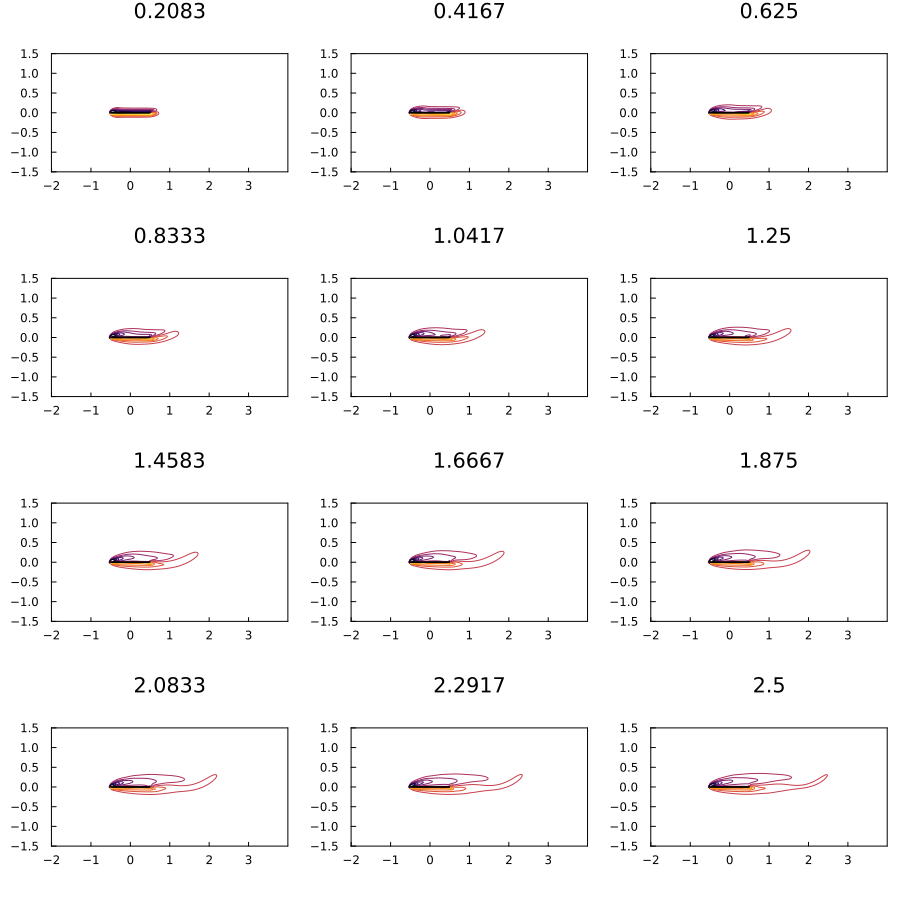

In [13]:
sol = integrator.sol
plt = plot(layout = (4,3), size = (900, 900), legend=:false)
tsnap = tfinal/12:tfinal/12:tfinal
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,clim=(-20,20),levels=range(-20,20,length=16),ylim=(-1.5,1.5),title="$(round(t,digits=4))")
end
plt

and compute and plot the force and moment

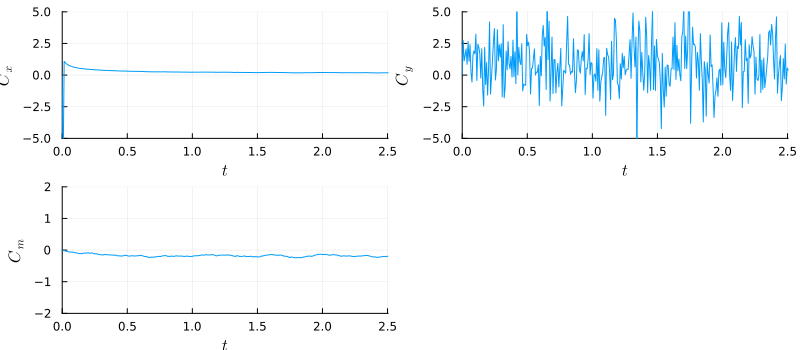

In [14]:
mom, fx, fy = force(sol,sys,1)

plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(-5,5),xlabel="\$t\$",ylabel="\$C_x\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-5,5),xlabel="\$t\$",ylabel="\$C_y\$",legend=:false),
plot(sol.t,2*mom,xlim=(0,Inf),ylim=(-2,2),xlabel="\$t\$",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)

We can also look at the y position and velocity. These are contained in
the joint state vector, `aux_state(u)`. We can use the functions `exogenous_position_vector`
and `exogenous_velocity_vector` to access them. (The index `[1]` below is required
because these functions return a vector of exogenous states for a particular joint.
There is only one component that is exogenous in this example.

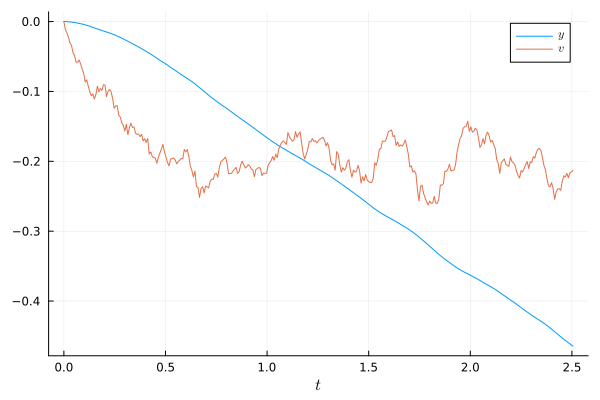

In [15]:
jointid = 1
y = map(u -> exogenous_position_vector(aux_state(u),m,jointid)[1],sol)
v = map(u -> exogenous_velocity_vector(aux_state(u),m,jointid)[1],sol)
plot(sol.t,y,label="\$y\$",xlabel="\$t\$")
plot!(sol.t,v,label="\$v\$")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*